In [1]:
""" Manually downloaded the Sign Language MNIST dataset to ~/tensorflow_datasets/sign_language_mnist """
import os
import pandas as pd

dataset_dir = os.path.join('/Users/carlos/tensorflow_datasets/sign_language_mnist')

train = pd.read_csv(dataset_dir + '/sign_mnist_train.csv')
test  = pd.read_csv(dataset_dir + '/sign_mnist_test.csv')

In [2]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
label,27455.0,12.318813,7.287552,0.0,6.0,13.0,19.0,24.0
pixel1,27455.0,145.419377,41.358555,0.0,121.0,150.0,174.0,255.0
pixel2,27455.0,148.500273,39.942152,0.0,126.0,153.0,176.0,255.0
pixel3,27455.0,151.247714,39.056286,0.0,130.0,156.0,178.0,255.0
pixel4,27455.0,153.546531,38.595247,0.0,133.0,158.0,179.0,255.0
...,...,...,...,...,...,...,...,...
pixel780,27455.0,162.736696,63.444008,0.0,125.0,184.0,207.0,255.0
pixel781,27455.0,162.906137,63.509210,0.0,128.0,184.0,207.0,255.0
pixel782,27455.0,161.966454,63.298721,0.0,128.0,182.0,206.0,255.0
pixel783,27455.0,161.137898,63.610415,0.0,128.0,182.0,204.0,255.0


In [5]:
""" Preprocessing so I can use the ImageDataGenerator and Train correctly.

Given the outputs above, each row is an image with the first column being its respective label.
We need to reshape and split (aka preprocess) the data to a nicer, usable format.

* Split labels into x
* Split images into y, but turn them from 1D of 784 pixels to a 28x28 image
* Reshape the (28, 28) to (28, 28, 1) to include the grayscale bit
* Do the same for testing dataset
"""
training_images = train.iloc[:,1:].values
training_labels = train.iloc[:,0].values

testing_images = test.iloc[:,1:].values
testing_labels = test.iloc[:,0].values

training_images = training_images.reshape(-1, 28, 28, 1)
testing_images = testing_images.reshape(-1, 28, 28, 1)

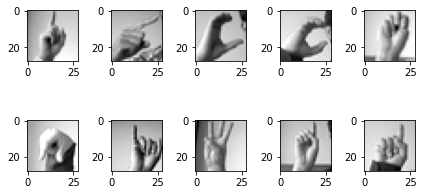

In [21]:
""" Show some of the training images """
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5) 
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(training_images[k].reshape(28, 28), cmap='gray')
        k += 1
    plt.tight_layout()

In [39]:
""" Define the model """
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax')
])

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)             

In [40]:
""" Create ImageDataGenerators for training and validation """
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(training_images, training_labels)
validation_generator = validation_datagen.flow(testing_images, testing_labels)

In [41]:
""" Train and evaluate model """
history = model.fit(
    train_generator,
    epochs=25,
    batch_size=10,
    validation_data=validation_generator
)

model.evaluate(testing_images, testing_labels)

Epoch 1/25
858/858 [==============================] - 18s 21ms/step - loss: 2.6140 - accuracy: 0.2025 - val_loss: 1.6705 - val_accuracy: 0.4336
Epoch 2/25
858/858 [==============================] - 19s 22ms/step - loss: 1.8208 - accuracy: 0.4168 - val_loss: 1.1048 - val_accuracy: 0.6180
Epoch 3/25
858/858 [==============================] - 19s 22ms/step - loss: 1.4361 - accuracy: 0.5344 - val_loss: 0.9033 - val_accuracy: 0.7018
Epoch 4/25
858/858 [==============================] - 19s 22ms/step - loss: 1.1999 - accuracy: 0.6090 - val_loss: 0.6463 - val_accuracy: 0.7697
Epoch 5/25
858/858 [==============================] - 19s 22ms/step - loss: 1.0160 - accuracy: 0.6691 - val_loss: 0.4832 - val_accuracy: 0.8417
Epoch 6/25
858/858 [==============================] - 19s 22ms/step - loss: 0.8967 - accuracy: 0.7005 - val_loss: 0.4189 - val_accuracy: 0.8685
Epoch 7/25
858/858 [==============================] - 18s 21ms/step - loss: 0.7995 - accuracy: 0.7337 - val_loss: 0.3797 - val_accuracy:

[262.83673095703125, 0.5885387659072876]

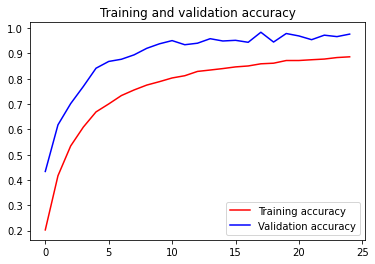

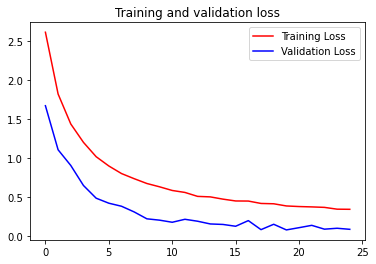

In [42]:
""" Visualize the accuracy and loss for training and validation """
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test Results

### Experiment 1

* Model
    * Convolutions: 2
    * Dense hidden layer: 512
    * `sigmoid` activation in output layer (whoops... I meant to use `softmax`, will try that next)

* Compile
    * Optimizer: Adam

* Fit
    * epochs: 10
    * batch_size: 10

* Results
    * Evaluation yielded 63% accuracy

I'll change `sigmoid` to `softmax` since I'm dealing with 25 classes and up the epochs to 15

---
### Experiment 2

Same as first experiment, but changed:

* `sigmoid` output activation to `softmax` activation
* epochs to 15

Surprisingly, the change to `softmax` had little effect. The number of epochs yielded the biggest change... What would happen if I introduced a 3rd convolution?

---
### Experiment 3

Wow! Adding the 3rd convolution lowered the evaluated accuracy from 67% to 41%!
I'll go back to 2 convolutions, but now I'm curious about whether the number of epochs or the 512 hidden units should be changed. Let's try it out.

---
### Experiment 4

Changes:
* 512 Dense Layer => 1024

This yielded the best results so far and the visualization of the training and validation looks great.
* loss: 0.3213 - accuracy: 0.8923
* val_loss: 0.1248 - val_accuracy: 0.9580
* evaluated accuracy: 76.8%

However, with the accuracies being so high and the evaluation being so low, I'm worried that doing more epochs would start overfitting. Let's try it out.

---
### Experiment 5

Changes:
* `epochs=25`

Things look good during training, but then the evalutation scored lower than Experiment 4. The last experiment I want to try before moving to the next course is using a Dropout layer.
* loss: 0.2377 - accuracy: 0.9203
* val_loss: 0.1052 - val_accuracy: 0.9649
* evaluated accuracy: 67.2%

---
### Experiment 6 (last one)

Changes:
* `Dropout(0.2)`

This performed worse than Experiment 5! Looks like Experiment 5 is the winner
* loss: 0.3405 - accuracy: 0.8868
* val_loss: 0.0835 - val_accuracy: 0.9766
* evaluated accuracy: 58.8%

---
## Conclusion
Preprocessing was _much_ easier when I was able to use Pandas and the `iloc` slicing to split and reshape the data. Most of my hypotheses during experimentation were correct which feels pretty good and tells me that I'm understanding this more and more. However, there were some hypotheses that I got wrong, like adding the 3rd convolution.

I think getting better at visualizations to explore and investigate will make me better at tuning and experimenting with different parameters. I'm also excited to jump into Tensorboard!

